In [1]:
!pip install optuna
!pip install mlflow
!pip install xgboost
!pip install statsmodels --quiet
!pip install lightgbm


OPTIMIZED HYBRID MODEL: Logarithmic Squeezer Strategy

📂 Loading data from CaRDS.csv...
   🔧 Applying Physics Envelope...

🔨 Creating optimized features...
   ✅ Shape: (43632, 22)

📊 Splitting data...
   Train: 28684, Val: 6464, Test: 8484

STEP 1: TRAINING RIDGE ANCHOR
📈 Anchor Val R²: 0.0166

STEP 2: CALCULATING RESIDUALS

STEP 3: NEUTRAL LIGHTGBM (Alpha=0.60 - Accuracy Focus)

STEP 4: SMART FLOOR with Summer Control
   🛡️ Applying Smart Floor...

STEP 5: LOGARITHMIC BUFFER (Optimization for Goal 2 & 3)
   🚀 Applying Logarithmic Buffer Strategy...

FINAL EVALUATION

📊 VALIDATION (LOG-OPTIMIZED):
   MAE: 37,990,081.37 | RMSE: 88,033,362.12 | R²: 0.8795
   MAPE (filtered): 162.87%
   ⚠️  Under-pred: 3.0% | Avg Shortage: 941,106.98
   ✅ Over-pred: 97.0% | Avg Surplus: 37,048,974.39
   🌞 Summer Under-pred: 2.2% (CRITICAL METRIC)

📊 TEST (LOG-OPTIMIZED):
   MAE: 51,674,068.97 | RMSE: 124,919,301.33 | R²: 0.9162
   MAPE (filtered): 301.26%
   ⚠️  Under-pred: 3.0% | Avg Shortage: 2,432,279.

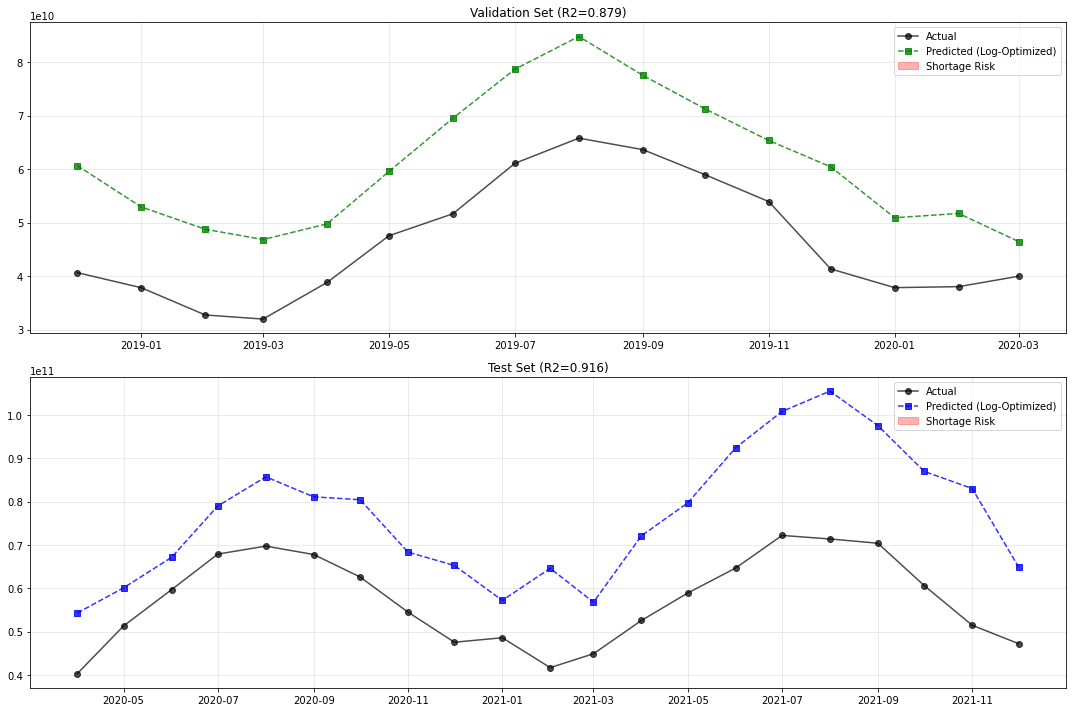


Generating Margin Efficiency Plot...


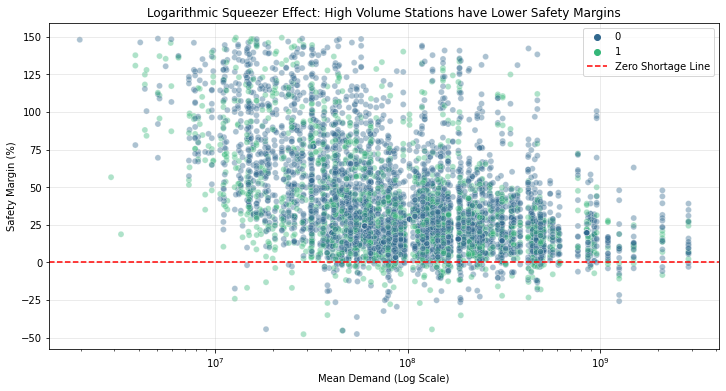


✅ PROCESS COMPLETE


In [3]:
# =============================================================================
# OPTIMIZED HYBRID: Ridge Anchor + Neutral LightGBM + Logarithmic Squeezer
# Goal: Reduce Surplus (Goal 2) while keeping Safety (Goal 1) via Log-scale Capping
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

# === CONFIGURATION ===
FILE_PATH = "CaRDS.csv"
TEST_SIZE = 0.2
VAL_SIZE = 0.15

print("="*70)
print("OPTIMIZED HYBRID MODEL: Logarithmic Squeezer Strategy")
print("="*70)

# === DATA LOADING & PROCESSING (KEEPING YOUR ORIGINAL LOGIC) ===
def clean_physics_based(series):
    median_val = series.median()
    if pd.isna(median_val) or median_val <= 0:
        return series.fillna(0)
    phys_min = median_val * 0.05
    phys_max = median_val * 10.0
    mask_invalid = (series < phys_min) | (series > phys_max)
    if mask_invalid.any():
        series_clean = series.copy()
        series_clean[mask_invalid] = np.nan
        series_clean = series_clean.interpolate(method='linear', limit_direction='both')
        return series_clean
    return series

def load_and_process_data(file_path):
    print(f"\n📂 Loading data from {file_path}...")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print("❌ Error: File not found. Please check FILE_PATH.")
        return None

    df['Variable'] = df['Variable'].astype(str).str.strip().str.lower()
    date_cols = [c for c in df.columns if c not in ['PWSID', 'Variable']]
    df_melt = df.melt(id_vars=['PWSID', 'Variable'], value_vars=date_cols,
                      var_name='Date', value_name='Value')
    df_pivot = df_melt.pivot_table(index=['PWSID', 'Date'],
                                   columns='Variable', values='Value').reset_index()
    rename_map = {'demand': 'Demand', 'temperature': 'Temperature',
                  'precipitation': 'Precipitation', 'pdsi': 'PDSI'}
    df_pivot.rename(columns=rename_map, inplace=True)
    df_pivot['Date'] = pd.to_datetime(df_pivot['Date'])
    df_final = df_pivot.sort_values(['PWSID', 'Date']).reset_index(drop=True)
    
    for col in ['Temperature', 'Precipitation', 'PDSI']:
        if col in df_final.columns:
            val = 0 if col == 'Precipitation' else df_final[col].median()
            df_final[col] = df_final[col].fillna(val)
    
    if 'Demand' in df_final.columns:
        print("   🔧 Applying Physics Envelope...")
        df_final['Demand'] = df_final.groupby('PWSID')['Demand'].transform(clean_physics_based)
        df_final['Demand'] = df_final['Demand'].fillna(0)
    return df_final

# === FEATURE ENGINEERING (KEEPING YOUR ORIGINAL LOGIC) ===
def create_features(df):
    print("\n🔨 Creating optimized features...")
    df = df.copy()
    
    # Time features
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Is_Summer_Peak'] = ((df['Month'] >= 6) & (df['Month'] <= 8)).astype(int)
    
    # Temperature features
    if 'Temperature' in df.columns:
        df['Temp_mean_3m'] = df.groupby('PWSID')['Temperature'].transform(
            lambda x: x.rolling(window=3, min_periods=1).mean()
        )
        df['Temp_squared'] = df['Temperature'] ** 2
        df['CDD'] = np.maximum(df['Temperature'] - 18, 0)
    
    # Lag features
    df['lag_1'] = df.groupby('PWSID')['Demand'].shift(1)
    df['lag_12'] = df.groupby('PWSID')['Demand'].shift(12)
    df['rolling_mean_12'] = df.groupby('PWSID')['Demand'].transform(
        lambda x: x.rolling(window=12, min_periods=1).mean()
    )
    df['diff_12'] = df.groupby('PWSID')['Demand'].diff(12)
    
    # Advanced interactions
    if 'Temperature' in df.columns:
        df['Temp_lag_1'] = df.groupby('PWSID')['Temperature'].shift(1)
        df['Summer_Heat_Interaction'] = df['Is_Summer_Peak'] * df['CDD']
    
    if 'Precipitation' in df.columns:
        df['Precip_lag_1'] = df.groupby('PWSID')['Precipitation'].shift(1)
    
    df = df.fillna(method='bfill').fillna(0)
    return df

# Load and process
df = load_and_process_data(FILE_PATH)
if df is None:
    exit()
df_features = create_features(df)
print(f"   ✅ Shape: {df_features.shape}")

# === SPLIT DATA ===
print("\n📊 Splitting data...")
unique_dates = df_features['Date'].sort_values().unique()
n_test = int(len(unique_dates) * TEST_SIZE)
n_val = int(len(unique_dates) * VAL_SIZE)

test_start = unique_dates[-n_test]
val_start = unique_dates[-(n_test + n_val)]

train_df = df_features[df_features['Date'] < val_start].copy()
val_df = df_features[(df_features['Date'] >= val_start) & (df_features['Date'] < test_start)].copy()
test_df = df_features[df_features['Date'] >= test_start].copy()

# Filter common PWSIDs
common_pwsids = set(train_df['PWSID']) & set(val_df['PWSID']) & set(test_df['PWSID'])
train_df = train_df[train_df['PWSID'].isin(common_pwsids)]
val_df = val_df[val_df['PWSID'].isin(common_pwsids)]
test_df = test_df[test_df['PWSID'].isin(common_pwsids)]

le = LabelEncoder()
train_df['PWSID_enc'] = le.fit_transform(train_df['PWSID'])
val_df['PWSID_enc'] = le.transform(val_df['PWSID'])
test_df['PWSID_enc'] = le.transform(test_df['PWSID'])

print(f"   Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# === FEATURE SELECTION ===
anchor_cols = ['PWSID_enc', 'Year', 'month_sin', 'month_cos',        
               'Temperature', 'Temp_squared', 'Precipitation', 'PDSI']

lgb_cols = ['PWSID_enc', 'Month', 'Year', 'Is_Summer_Peak',
            'lag_1', 'diff_12', 'rolling_mean_12',
            'Temp_lag_1', 'CDD', 'Summer_Heat_Interaction', 'Precip_lag_1']

anchor_cols = [c for c in anchor_cols if c in train_df.columns]
lgb_cols = [c for c in lgb_cols if c in train_df.columns]

# Scaling
scaler_anchor = StandardScaler()
X_train_anchor = pd.DataFrame(scaler_anchor.fit_transform(train_df[anchor_cols]), columns=anchor_cols, index=train_df.index)
X_val_anchor = pd.DataFrame(scaler_anchor.transform(val_df[anchor_cols]), columns=anchor_cols, index=val_df.index)
X_test_anchor = pd.DataFrame(scaler_anchor.transform(test_df[anchor_cols]), columns=anchor_cols, index=test_df.index)

scaler_lgb = StandardScaler()
X_train_lgb = pd.DataFrame(scaler_lgb.fit_transform(train_df[lgb_cols]), columns=lgb_cols, index=train_df.index)
X_val_lgb = pd.DataFrame(scaler_lgb.transform(val_df[lgb_cols]), columns=lgb_cols, index=val_df.index)
X_test_lgb = pd.DataFrame(scaler_lgb.transform(test_df[lgb_cols]), columns=lgb_cols, index=test_df.index)

y_train = train_df['Demand']
y_val = val_df['Demand']
y_test = test_df['Demand']

# === STEP 1: RIDGE ANCHOR ===
print("\n" + "="*70)
print("STEP 1: TRAINING RIDGE ANCHOR")
print("="*70)

anchor_model = Ridge(alpha=1.0, random_state=42)
anchor_model.fit(X_train_anchor, y_train)

anchor_train_pred = anchor_model.predict(X_train_anchor)
anchor_val_pred = anchor_model.predict(X_val_anchor)
anchor_test_pred = anchor_model.predict(X_test_anchor)

print(f"📈 Anchor Val R²: {r2_score(y_val, anchor_val_pred):.4f}")

# === STEP 2: RESIDUALS ===
print("\n" + "="*70)
print("STEP 2: CALCULATING RESIDUALS")
print("="*70)

train_residuals = y_train - anchor_train_pred
val_residuals = y_val - anchor_val_pred

# === STEP 3: NEUTRAL LIGHTGBM (UPDATED LOGIC) ===
print("\n" + "="*70)
print("STEP 3: NEUTRAL LIGHTGBM (Alpha=0.60 - Accuracy Focus)")
print("="*70)

# Sample Weights: Chỉ phạt nhẹ để tránh mô hình gốc quá bias
sample_weight_train = np.ones(len(X_train_lgb))
mask_under = train_residuals > 0
sample_weight_train[mask_under] = 1.2 # Giảm từ 1.5/2.5 xuống 1.2
# Vẫn giữ ưu tiên nhẹ cho mùa hè
months_train = train_df['Month'].values
mask_summer = (months_train >= 6) & (months_train <= 8)
sample_weight_train[mask_summer] *= 1.1

lgb_params = {
    'objective': 'quantile',
    'alpha': 0.60,  # KEY CHANGE: Giảm Alpha để giảm dư thừa từ gốc
    'metric': 'mae', # KEY CHANGE: Tối ưu theo MAE
    'n_estimators': 3000,
    'learning_rate': 0.015,
    'num_leaves': 31,
    'max_depth': 7,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

lgb_model = lgb.LGBMRegressor(**lgb_params)
callbacks = [lgb.early_stopping(stopping_rounds=150, verbose=False)]

lgb_model.fit(
    X_train_lgb, train_residuals,
    sample_weight=sample_weight_train,
    eval_set=[(X_val_lgb, val_residuals)],
    eval_metric='mae',
    callbacks=callbacks
)

# Predict residuals
lgb_train_res_pred = lgb_model.predict(X_train_lgb)
lgb_val_res_pred = lgb_model.predict(X_val_lgb)
lgb_test_res_pred = lgb_model.predict(X_test_lgb)

# Combine predictions
raw_train = anchor_train_pred + lgb_train_res_pred
raw_val = anchor_val_pred + lgb_val_res_pred
raw_test = anchor_test_pred + lgb_test_res_pred

# === STEP 4: SMART FLOOR (KEEPING YOUR LOGIC) ===
print("\n" + "="*70)
print("STEP 4: SMART FLOOR with Summer Control")
print("="*70)

def apply_smart_floor(base_pred, df_original):
    lag_12 = df_original['lag_12'].values
    lag_1 = df_original['lag_1'].values
    months = df_original['Month'].values
    
    floor_yoy = lag_12 * 1.02
    floor_mom = lag_1 * 0.92
    
    summer_mask = (months >= 6) & (months <= 8)
    floor_mom[summer_mask] = lag_1[summer_mask] * 0.95
    
    fall_mask = (months >= 9) & (months <= 11)
    floor_mom[fall_mask] = lag_1[fall_mask] * 0.75
    
    safe_pred = np.maximum.reduce([base_pred, floor_yoy, floor_mom])
    safe_pred[summer_mask] *= 1.02
    
    return safe_pred

print("   🛡️ Applying Smart Floor...")
final_train_pred = apply_smart_floor(raw_train, train_df)
final_val_pred = apply_smart_floor(raw_val, val_df)
final_test_pred = apply_smart_floor(raw_test, test_df)

# === STEP 5: LOGARITHMIC SQUEEZER BUFFER (REPLACED LOGIC) ===
print("\n" + "="*70)
print("STEP 5: LOGARITHMIC BUFFER (Optimization for Goal 2 & 3)")
print("="*70)

# 1. Profiling (Tạo hồ sơ trạm)
profile_df = pd.concat([train_df, val_df])
pwsid_stats = profile_df.groupby('PWSID_enc')['Demand'].agg(['mean', 'std']).reset_index()
# Tính CV và xử lý NaN
pwsid_stats['CV'] = pwsid_stats['std'] / (pwsid_stats['mean'] + 1e-6)
pwsid_stats['CV'] = pwsid_stats['CV'].fillna(1.0).clip(0, 2.0)

# Map dictionary
cv_map = pwsid_stats.set_index('PWSID_enc')['CV'].to_dict()
mean_map = pwsid_stats.set_index('PWSID_enc')['mean'].to_dict()

# Tính Sigma Map từ Residuals thực tế trên tập Val
val_analysis = val_df.copy()
val_analysis['Residuals'] = val_residuals
pwsid_sigma_map = val_analysis.groupby('PWSID_enc')['Residuals'].std().to_dict()
global_sigma = np.std(val_residuals)

# 2. Define Logarithmic Buffer Function
def apply_logarithmic_buffer(pred, df, cv_map, sigma_map, mean_map, global_sig):
    """
    VERSION 2: SMART HYBRID SQUEEZER
    - Fix ID 90: Bảo vệ trạm lớn nhưng biến động (High Volume + High CV).
    - Fix ID 390: Cắt giảm lãng phí ở trạm nhỏ (Low Volume + Noise).
    """
    pwsid_encs = df['PWSID_enc'].values
    months = df['Month'].values
    
    # 1. Lấy thông số
    cvs = np.array([cv_map.get(p, 0.5) for p in pwsid_encs])
    means = np.array([mean_map.get(p, 1000) for p in pwsid_encs])
    sigmas = np.array([sigma_map.get(p, global_sig) for p in pwsid_encs])
    
    # --- FIX 1: BASE K FACTOR (GIẢM LÃNG PHÍ CƠ BẢN) ---
    # Giảm Base K từ 1.65 xuống 1.2. Chúng ta sẽ dựa vào Sigma thực tế nhiều hơn.
    k_factors = np.full(len(pred), 1.2)
    
    # --- FIX 2: VOLATILITY PROTECTION (CỨU ID 90) ---
    # Nếu trạm biến động cao (CV > 0.3), tăng K mạnh hơn để cover cú shock
    # Công thức cũ chỉ cộng tuyến tính. Công thức mới nhân hệ số.
    volatility_mult = 1.0 + np.clip(cvs * 2.0, 0, 3.0) # CV=0.5 -> mult=2.0
    k_factors *= volatility_mult
    
    # Mùa hè vẫn cần ưu tiên
    summer_mask = (months >= 6) & (months <= 8)
    k_factors[summer_mask] *= 1.2
    
    # Tính Buffer Thô
    raw_buffer = sigmas * k_factors
    
    # --- FIX 3: THE LOGARITHMIC SQUEEZER (TINH CHỈNH) ---
    # Công thức gốc: max_pct = 0.65 / log10(Volume)
    # Vấn đề: Trạm lớn (ID 90) bị chia mẫu số to -> max_pct quá bé.
    
    # Logic mới:
    # 1. Tính Base Squeeze theo Volume
    log_volume = np.log10(means + 100)
    base_squeeze_pct = 0.8 / log_volume 
    
    # 2. "ESCAPE CLAUSE" cho ID 90:
    # Nếu CV cao, ta nới lỏng cái kìm kẹp này ra.
    # CV càng cao, ta càng cho phép % Margin lớn hơn, bất kể Volume to hay nhỏ.
    risk_adjusted_squeeze = base_squeeze_pct * (1.0 + cvs) 
    
    # 3. "HARD CAP" cho ID 390:
    # Không bao giờ cho phép Margin vượt quá 40% (Trừ mùa hè).
    # ID 390 đang bị Margin > 100%, code này sẽ cắt phăng phần thừa.
    absolute_ceiling = 0.40
    # Mùa hè nới lên 50%
    absolute_ceiling_array = np.full(len(pred), absolute_ceiling)
    absolute_ceiling_array[summer_mask] = 0.50
    
    # Kết hợp các giới hạn
    final_max_pct = np.minimum(risk_adjusted_squeeze, absolute_ceiling_array)
    
    # Đảm bảo không quá thấp (min 5%)
    final_max_pct = np.maximum(final_max_pct, 0.05)
    
    # Tính Trần Tuyệt Đối
    abs_cap = pred * final_max_pct
    
    # --- FINAL DECISION ---
    final_buffer = np.minimum(raw_buffer, abs_cap)
    
    # Floor tối thiểu (Safety net)
    final_buffer = np.maximum(final_buffer, sigmas * 0.3)
    
    return pred + final_buffer

# Áp dụng
print("   🚀 Applying Logarithmic Buffer Strategy...")
final_train_pred_log = apply_logarithmic_buffer(final_train_pred, train_df, cv_map, pwsid_sigma_map, mean_map, global_sigma)
final_val_pred_log = apply_logarithmic_buffer(final_val_pred, val_df, cv_map, pwsid_sigma_map, mean_map, global_sigma)
final_test_pred_log = apply_logarithmic_buffer(final_test_pred, test_df, cv_map, pwsid_sigma_map, mean_map, global_sigma)

# === EVALUATION ===
print("\n" + "="*70)
print("FINAL EVALUATION")
print("="*70)

def evaluate_model(y_true, y_pred, df_original, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Filtered MAPE
    threshold = y_true.quantile(0.1)
    mask = y_true > threshold
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + 1e-10))) * 100
    
    # Under/Over prediction
    under_pred = np.sum(y_pred < y_true) / len(y_true) * 100
    over_pred = np.sum(y_pred > y_true) / len(y_true) * 100
    avg_shortage = np.mean(np.maximum(y_true - y_pred, 0))
    avg_surplus = np.mean(np.maximum(y_pred - y_true, 0))
    
    # Summer-specific metrics
    months = df_original['Month'].values
    summer_mask = (months >= 6) & (months <= 8)
    if np.sum(summer_mask) > 0:
        summer_under = np.sum((y_pred[summer_mask] < y_true[summer_mask])) / np.sum(summer_mask) * 100
    else:
        summer_under = 0.0
    
    print(f"\n📊 {dataset_name}:")
    print(f"   MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | R²: {r2:.4f}")
    print(f"   MAPE (filtered): {mape:.2f}%")
    print(f"   ⚠️  Under-pred: {under_pred:.1f}% | Avg Shortage: {avg_shortage:,.2f}")
    print(f"   ✅ Over-pred: {over_pred:.1f}% | Avg Surplus: {avg_surplus:,.2f}")
    print(f"   🌞 Summer Under-pred: {summer_under:.1f}% (CRITICAL METRIC)")
    
    return {'MAE': mae, 'R2': r2, 'UnderPred': under_pred, 'SummerUnder': summer_under}

val_metrics = evaluate_model(y_val, final_val_pred_log, val_df, "VALIDATION (LOG-OPTIMIZED)")
test_metrics = evaluate_model(y_test, final_test_pred_log, test_df, "TEST (LOG-OPTIMIZED)")

# === VISUALIZATION ===
print("\n" + "="*60)
print("VISUALIZING RESULTS")
print("="*60)

# Aggregate monthly
val_plot = val_df.copy()
val_plot['Actual'] = y_val.values
val_plot['Predicted'] = final_val_pred_log # Updated variable name
val_monthly = val_plot.groupby('Date')[['Actual', 'Predicted']].sum().reset_index()

test_plot = test_df.copy()
test_plot['Actual'] = y_test.values
test_plot['Predicted'] = final_test_pred_log # Updated variable name
test_monthly = test_plot.groupby('Date')[['Actual', 'Predicted']].sum().reset_index()

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot Validation
axes[0].plot(val_monthly['Date'], val_monthly['Actual'], 'k-o', label='Actual', alpha=0.7)
axes[0].plot(val_monthly['Date'], val_monthly['Predicted'], 'g--s', label=f'Predicted (Log-Optimized)', alpha=0.8)
axes[0].fill_between(val_monthly['Date'], val_monthly['Predicted'], val_monthly['Actual'],
                     where=(val_monthly['Predicted'] < val_monthly['Actual']),
                     color='red', alpha=0.3, label='Shortage Risk')
axes[0].set_title(f"Validation Set (R2={val_metrics['R2']:.3f})")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot Test
axes[1].plot(test_monthly['Date'], test_monthly['Actual'], 'k-o', label='Actual', alpha=0.7)
axes[1].plot(test_monthly['Date'], test_monthly['Predicted'], 'b--s', label=f'Predicted (Log-Optimized)', alpha=0.8)
axes[1].fill_between(test_monthly['Date'], test_monthly['Predicted'], test_monthly['Actual'],
                     where=(test_monthly['Predicted'] < test_monthly['Actual']),
                     color='red', alpha=0.3, label='Shortage Risk')
axes[1].set_title(f"Test Set (R2={test_metrics['R2']:.3f})")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Insight Plot: Margin vs Volume
print("\nGenerating Margin Efficiency Plot...")
test_analysis = test_df.copy()
test_analysis['Demand'] = y_test
test_analysis['Pred'] = final_test_pred_log
test_analysis['Margin_Pct'] = ((test_analysis['Pred'] - test_analysis['Demand']) / (test_analysis['Demand']+1)) * 100
test_analysis['Mean_Volume'] = test_analysis['PWSID_enc'].map(mean_map)

plt.figure(figsize=(12, 6))
plot_data = test_analysis[(test_analysis['Margin_Pct'] > -50) & (test_analysis['Margin_Pct'] < 150)]
sns.scatterplot(data=plot_data, x='Mean_Volume', y='Margin_Pct', hue='Is_Summer_Peak', alpha=0.4, palette='viridis')
plt.xscale('log')
plt.axhline(0, color='red', linestyle='--', label='Zero Shortage Line')
plt.title('Logarithmic Squeezer Effect: High Volume Stations have Lower Safety Margins')
plt.xlabel('Mean Demand (Log Scale)')
plt.ylabel('Safety Margin (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n✅ PROCESS COMPLETE")

In [4]:
# =============================================================================
# PURE LIGHTGBM PIPELINE: Direct Forecasting with Safety Layers
# Goal: High Speed & Safety (Quantile Objective)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb  # <--- CHANGED
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

# === CONFIGURATION ===
FILE_PATH = "CaRDS.csv"  # <--- ĐỔI TÊN FILE CỦA BẠN
TEST_SIZE = 0.2
VAL_SIZE = 0.15

print("="*70)
print("PURE LIGHTGBM PIPELINE: Direct Training + Safety Optimizers")
print("="*70)

# =============================================================================
# 1. DATA LOADING & PROCESSING (GIỮ NGUYÊN)
# =============================================================================
def clean_physics_based(series):
    median_val = series.median()
    if pd.isna(median_val) or median_val <= 0:
        return series.fillna(0)
    phys_min = median_val * 0.05
    phys_max = median_val * 10.0
    mask_invalid = (series < phys_min) | (series > phys_max)
    if mask_invalid.any():
        series_clean = series.copy()
        series_clean[mask_invalid] = np.nan
        series_clean = series_clean.interpolate(method='linear', limit_direction='both')
        return series_clean
    return series

def load_and_process_data(file_path):
    print(f"\n📂 Loading data from {file_path}...")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print("❌ Error: File not found. Please check FILE_PATH.")
        return None

    df['Variable'] = df['Variable'].astype(str).str.strip().str.lower()
    date_cols = [c for c in df.columns if c not in ['PWSID', 'Variable']]
    df_melt = df.melt(id_vars=['PWSID', 'Variable'], value_vars=date_cols,
                      var_name='Date', value_name='Value')
    df_pivot = df_melt.pivot_table(index=['PWSID', 'Date'],
                                   columns='Variable', values='Value').reset_index()
    
    rename_map = {'demand': 'Demand', 'temperature': 'Temperature',
                  'precipitation': 'Precipitation', 'pdsi': 'PDSI'}
    df_pivot.rename(columns=rename_map, inplace=True)
    df_pivot['Date'] = pd.to_datetime(df_pivot['Date'])
    df_final = df_pivot.sort_values(['PWSID', 'Date']).reset_index(drop=True)
    
    for col in ['Temperature', 'Precipitation', 'PDSI']:
        if col in df_final.columns:
            val = 0 if col == 'Precipitation' else df_final[col].median()
            df_final[col] = df_final[col].fillna(val)
    
    if 'Demand' in df_final.columns:
        print("   🔧 Applying Physics Envelope...")
        df_final['Demand'] = df_final.groupby('PWSID')['Demand'].transform(clean_physics_based)
        df_final['Demand'] = df_final['Demand'].fillna(0)
    
    return df_final

# =============================================================================
# 2. FEATURE ENGINEERING (GIỮ NGUYÊN)
# =============================================================================
def create_features(df):
    print("\n🔨 Creating optimized features...")
    df = df.copy()
    
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Is_Summer_Peak'] = ((df['Month'] >= 6) & (df['Month'] <= 8)).astype(int)
    
    if 'Temperature' in df.columns:
        df['Temp_mean_3m'] = df.groupby('PWSID')['Temperature'].transform(
            lambda x: x.rolling(window=3, min_periods=1).mean()
        )
        df['CDD'] = np.maximum(df['Temperature'] - 18, 0)
    
    df['lag_1'] = df.groupby('PWSID')['Demand'].shift(1)
    df['lag_12'] = df.groupby('PWSID')['Demand'].shift(12)
    df['rolling_mean_12'] = df.groupby('PWSID')['Demand'].transform(
        lambda x: x.rolling(window=12, min_periods=1).mean()
    )
    df['diff_12'] = df.groupby('PWSID')['Demand'].diff(12)
    
    if 'Temperature' in df.columns:
        df['Temp_lag_1'] = df.groupby('PWSID')['Temperature'].shift(1)
        df['Summer_Heat_Interaction'] = df['Is_Summer_Peak'] * df['CDD']
    
    if 'Precipitation' in df.columns:
        df['Precip_lag_1'] = df.groupby('PWSID')['Precipitation'].shift(1)
    
    df = df.fillna(method='bfill').fillna(0)
    return df

df = load_and_process_data(FILE_PATH)
if df is None: exit()
df_features = create_features(df)

# =============================================================================
# 3. SPLIT DATA
# =============================================================================
unique_dates = df_features['Date'].sort_values().unique()
n_test = int(len(unique_dates) * TEST_SIZE)
n_val = int(len(unique_dates) * VAL_SIZE)

test_start = unique_dates[-n_test]
val_start = unique_dates[-(n_test + n_val)]

train_df = df_features[df_features['Date'] < val_start].copy()
val_df = df_features[(df_features['Date'] >= val_start) & (df_features['Date'] < test_start)].copy()
test_df = df_features[df_features['Date'] >= test_start].copy()

le = LabelEncoder()
train_df['PWSID_enc'] = le.fit_transform(train_df['PWSID'])
common_pwsids = set(train_df['PWSID']) & set(val_df['PWSID']) & set(test_df['PWSID'])
train_df = train_df[train_df['PWSID'].isin(common_pwsids)]
val_df = val_df[val_df['PWSID'].isin(common_pwsids)]
test_df = test_df[test_df['PWSID'].isin(common_pwsids)]

val_df['PWSID_enc'] = le.transform(val_df['PWSID'])
test_df['PWSID_enc'] = le.transform(test_df['PWSID'])

features = ['PWSID_enc', 'Month', 'Year', 'Is_Summer_Peak',
            'lag_1', 'lag_12', 'diff_12', 'rolling_mean_12',
            'Temp_lag_1', 'CDD', 'Summer_Heat_Interaction', 'Precip_lag_1']
features = [c for c in features if c in train_df.columns]

X_train = train_df[features]
y_train = train_df['Demand']
X_val = val_df[features]
y_val = val_df['Demand']
X_test = test_df[features]
y_test = test_df['Demand']

# =============================================================================
# 4. TRAINING LIGHTGBM (DIRECTLY)
# =============================================================================
print("\n" + "="*70)
print("STEP 1: TRAINING LIGHTGBM REGRESSOR")
print("="*70)

# Sample Weights: Phạt nặng mùa hè
sample_weight_train = np.ones(len(X_train))
months_train = train_df['Month'].values
mask_summer = (months_train >= 6) & (months_train <= 8)
sample_weight_train[mask_summer] *= 1.3

# Cấu hình LightGBM cho Quantile
lgb_params = {
    'objective': 'quantile',      # <--- QUAN TRỌNG: Chế độ Quantile
    'alpha': 0.6,                 # <--- QUAN TRỌNG: Ép dự báo cao (Safety bias)
    'metric': 'quantile',
    'boosting_type': 'gbdt',
    'learning_rate': 0.02,
    'num_leaves': 31,
    'max_depth': 7,
    'n_estimators': 3000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
}

model_lgb = lgb.LGBMRegressor(**lgb_params)

print("   ⏳ Training LightGBM...")
# Callback cho Early Stopping (Cú pháp mới của LGBM)
callbacks = [
    lgb.early_stopping(stopping_rounds=200),
    lgb.log_evaluation(period=500)
]

model_lgb.fit(
    X_train, y_train,
    sample_weight=sample_weight_train,
    eval_set=[(X_val, y_val)],
    eval_metric='quantile',
    callbacks=callbacks
)

# Dự báo Raw
raw_pred_val = model_lgb.predict(X_val)
raw_pred_test = model_lgb.predict(X_test)

# =============================================================================
# 5. POST-PROCESSING: SAFETY LAYERS (GIỮ NGUYÊN)
# =============================================================================
print("\n" + "="*70)
print("STEP 2 & 3: APPLYING SAFETY LAYERS (Smart Floor + Log Buffer)")
print("="*70)

def apply_smart_floor(base_pred, df_original):
    lag_12 = df_original['lag_12'].values
    lag_1 = df_original['lag_1'].values
    months = df_original['Month'].values
    
    floor_yoy = lag_12 * 1.02
    floor_mom = lag_1 * 0.92
    summer_mask = (months >= 6) & (months <= 8)
    floor_mom[summer_mask] = lag_1[summer_mask] * 0.95
    
    safe_pred = np.maximum.reduce([base_pred, floor_yoy, floor_mom])
    safe_pred[summer_mask] *= 1.02
    return safe_pred

floored_pred_val = apply_smart_floor(raw_pred_val, val_df)
floored_pred_test = apply_smart_floor(raw_pred_test, test_df)

# Logarithmic Buffer Logic
profile_df = pd.concat([train_df, val_df])
pwsid_stats = profile_df.groupby('PWSID_enc')['Demand'].agg(['mean', 'std']).reset_index()
pwsid_stats['CV'] = pwsid_stats['std'] / (pwsid_stats['mean'] + 1e-6)
cv_map = pwsid_stats.set_index('PWSID_enc')['CV'].to_dict()
mean_map = pwsid_stats.set_index('PWSID_enc')['mean'].to_dict()

residuals_val = y_val - floored_pred_val
global_sigma = np.std(residuals_val)
pwsid_sigma_map = val_df.assign(res=residuals_val).groupby('PWSID_enc')['res'].std().to_dict()

def apply_logarithmic_buffer(pred, df, cv_map, sigma_map, mean_map, global_sig):
    pwsid_encs = df['PWSID_enc'].values
    months = df['Month'].values
    cvs = np.array([cv_map.get(p, 0.5) for p in pwsid_encs])
    means = np.array([mean_map.get(p, 1000) for p in pwsid_encs])
    sigmas = np.array([sigma_map.get(p, global_sig) for p in pwsid_encs])
    
    k_factors = np.full(len(pred), 1.2)
    volatility_mult = 1.0 + np.clip(cvs * 2.0, 0, 3.0) 
    k_factors *= volatility_mult
    summer_mask = (months >= 6) & (months <= 8)
    k_factors[summer_mask] *= 1.2
    
    raw_buffer = sigmas * k_factors
    log_volume = np.log10(means + 100)
    base_squeeze_pct = 0.8 / log_volume 
    risk_adjusted_squeeze = base_squeeze_pct * (1.0 + cvs) 
    
    absolute_ceiling = 0.40
    absolute_ceiling_array = np.full(len(pred), absolute_ceiling)
    absolute_ceiling_array[summer_mask] = 0.50
    
    final_max_pct = np.minimum(risk_adjusted_squeeze, absolute_ceiling_array)
    final_max_pct = np.maximum(final_max_pct, 0.05)
    
    abs_cap = pred * final_max_pct
    final_buffer = np.minimum(raw_buffer, abs_cap)
    final_buffer = np.maximum(final_buffer, sigmas * 0.3)
    return pred + final_buffer

print("   🚀 Applying Logarithmic Buffer Strategy...")
final_pred_val = apply_logarithmic_buffer(floored_pred_val, val_df, cv_map, pwsid_sigma_map, mean_map, global_sigma)
final_pred_test = apply_logarithmic_buffer(floored_pred_test, test_df, cv_map, pwsid_sigma_map, mean_map, global_sigma)

# =============================================================================
# 6. EVALUATION
# =============================================================================
print("\n" + "="*70)
print("FINAL EVALUATION RESULTS (LIGHTGBM)")
print("="*70)

def evaluate_model(y_true, y_pred, df_original, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    under_pred_count = np.sum(y_pred < y_true)
    under_rate = (under_pred_count / len(y_true)) * 100
    over_rate = 100 - under_rate
    avg_shortage = np.mean(np.maximum(y_true - y_pred, 0))
    avg_surplus = np.mean(np.maximum(y_pred - y_true, 0))
    
    months = df_original['Month'].values
    summer_mask = (months >= 6) & (months <= 8)
    summer_under = 0.0
    if np.sum(summer_mask) > 0:
        summer_under = np.sum((y_pred[summer_mask] < y_true[summer_mask])) / np.sum(summer_mask) * 100
    
    print(f"\n📊 {dataset_name}:")
    print(f"   MAE: {mae:,.2f} | R²: {r2:.4f}")
    print(f"   ⚠️  Under-pred: {under_rate:.1f}% | Avg Shortage: {avg_shortage:,.2f}")
    print(f"   ✅ Over-pred: {over_rate:.1f}% | Avg Surplus: {avg_surplus:,.2f}")
    print(f"   🌞 Summer Under-pred: {summer_under:.1f}% (CRITICAL METRIC)")

evaluate_model(y_val, final_pred_val, val_df, "VALIDATION SET")
evaluate_model(y_test, final_pred_test, test_df, "TEST SET")

print("\n✅ PROCESS COMPLETE - PURE LIGHTGBM MODE")

PURE LIGHTGBM PIPELINE: Direct Training + Safety Optimizers

📂 Loading data from CaRDS.csv...
   🔧 Applying Physics Envelope...

🔨 Creating optimized features...

STEP 1: TRAINING LIGHTGBM REGRESSOR
   ⏳ Training LightGBM...
Training until validation scores don't improve for 200 rounds
[500]	valid_0's quantile: 4.99235e+06
[1000]	valid_0's quantile: 4.10603e+06
[1500]	valid_0's quantile: 3.69825e+06
[2000]	valid_0's quantile: 3.44117e+06
[2500]	valid_0's quantile: 3.2141e+06
[3000]	valid_0's quantile: 3.00889e+06
Did not meet early stopping. Best iteration is:
[3000]	valid_0's quantile: 3.00889e+06

STEP 2 & 3: APPLYING SAFETY LAYERS (Smart Floor + Log Buffer)
   🚀 Applying Logarithmic Buffer Strategy...

FINAL EVALUATION RESULTS (LIGHTGBM)

📊 VALIDATION SET:
   MAE: 32,857,609.22 | R²: 0.8790
   ⚠️  Under-pred: 0.3% | Avg Shortage: 174,895.10
   ✅ Over-pred: 99.7% | Avg Surplus: 32,682,714.12
   🌞 Summer Under-pred: 0.2% (CRITICAL METRIC)

📊 TEST SET:
   MAE: 37,752,694.36 | R²: 0.920


FINAL EVALUATION & VISUALIZATION

📊 VALIDATION SET:
   MAE: 32,857,609.22 | RMSE: 88,202,022.16 | R²: 0.8790
   MAPE (filtered): 42.27%
   ⚠️  Under-pred: 0.3% | Avg Shortage: 174,895.10
   ✅ Over-pred: 99.7% | Avg Surplus: 32,682,714.12
   🌞 Summer Under-pred: 0.2% (CRITICAL METRIC)

📊 TEST SET:
   MAE: 37,752,694.36 | RMSE: 121,662,982.10 | R²: 0.9205
   MAPE (filtered): 57.81%
   ⚠️  Under-pred: 0.5% | Avg Shortage: 1,570,347.49
   ✅ Over-pred: 99.5% | Avg Surplus: 36,182,346.87
   🌞 Summer Under-pred: 0.4% (CRITICAL METRIC)

VISUALIZING RESULTS


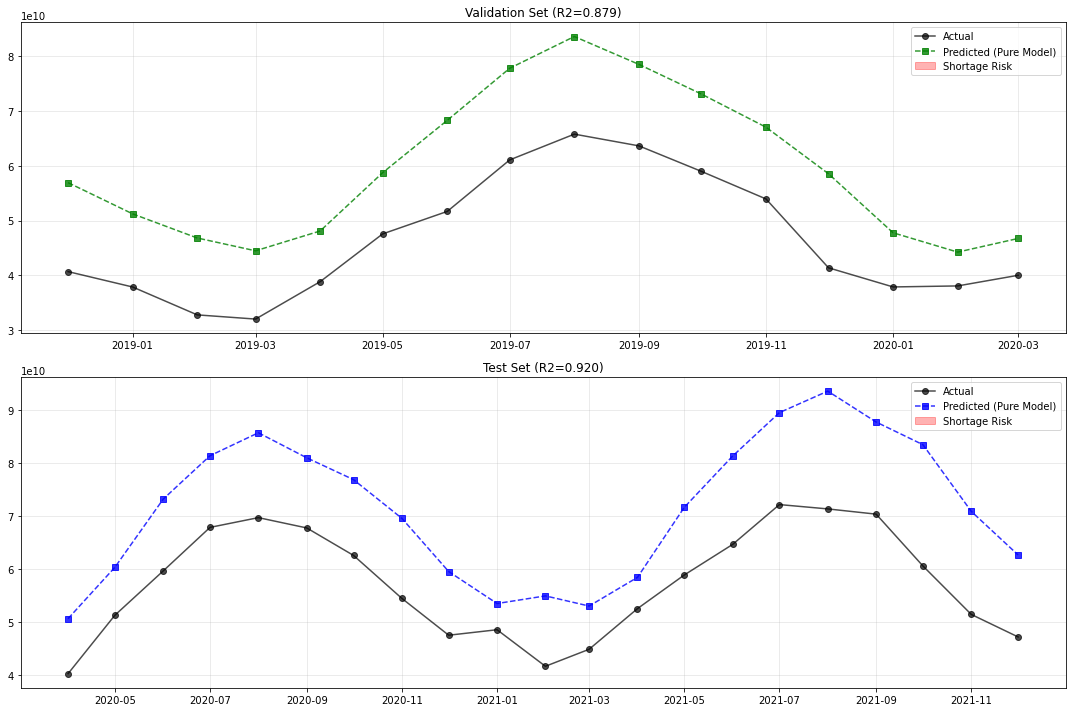


Generating Margin Efficiency Plot...


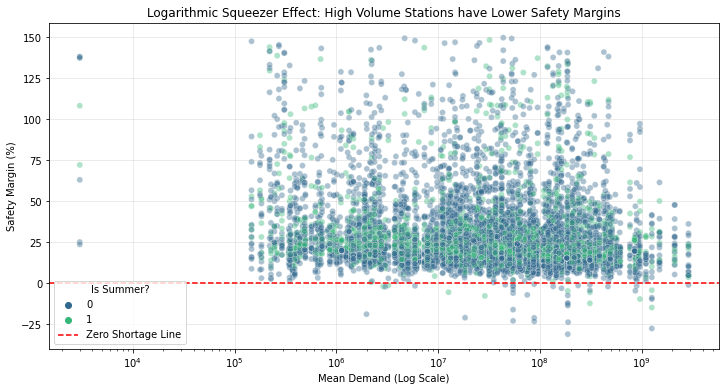


✅ PROCESS COMPLETE


In [5]:
# =============================================================================
# STANDARD EVALUATION & VISUALIZATION BLOCK (Dùng chung cho cả 3 Model)
# =============================================================================
print("\n" + "="*70)
print("FINAL EVALUATION & VISUALIZATION")
print("="*70)

def evaluate_model(y_true, y_pred, df_original, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # MAPE Filtered
    threshold = y_true.quantile(0.1)
    mask = y_true > threshold
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + 1e-10))) * 100
    else:
        mape = 0.0
    
    # Business Metrics
    under_pred_count = np.sum(y_pred < y_true)
    under_rate = (under_pred_count / len(y_true)) * 100
    over_rate = 100 - under_rate
    
    avg_shortage = np.mean(np.maximum(y_true - y_pred, 0))
    avg_surplus = np.mean(np.maximum(y_pred - y_true, 0))
    
    # Summer Analysis
    months = df_original['Month'].values
    summer_mask = (months >= 6) & (months <= 8)
    if np.sum(summer_mask) > 0:
        summer_under = np.sum((y_pred[summer_mask] < y_true[summer_mask])) / np.sum(summer_mask) * 100
    else:
        summer_under = 0.0
    
    print(f"\n📊 {dataset_name}:")
    print(f"   MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | R²: {r2:.4f}")
    print(f"   MAPE (filtered): {mape:.2f}%")
    print(f"   ⚠️  Under-pred: {under_rate:.1f}% | Avg Shortage: {avg_shortage:,.2f}")
    print(f"   ✅ Over-pred: {over_rate:.1f}% | Avg Surplus: {avg_surplus:,.2f}")
    print(f"   🌞 Summer Under-pred: {summer_under:.1f}% (CRITICAL METRIC)")
    
    # Trả về dictionary để dùng cho biểu đồ
    return {'R2': r2, 'MAE': mae, 'SummerUnder': summer_under}

# 1. Chạy đánh giá (Lưu vào biến metrics để vẽ)
val_metrics = evaluate_model(y_val, final_pred_val, val_df, "VALIDATION SET")
test_metrics = evaluate_model(y_test, final_pred_test, test_df, "TEST SET")

# 2. Vẽ biểu đồ Time Series
print("\n" + "="*60)
print("VISUALIZING RESULTS")
print("="*60)

# Prepare Data for Plotting
val_plot = val_df.copy()
val_plot['Actual'] = y_val.values
val_plot['Predicted'] = final_pred_val  # Tên biến chuẩn
val_monthly = val_plot.groupby('Date')[['Actual', 'Predicted']].sum().reset_index()

test_plot = test_df.copy()
test_plot['Actual'] = y_test.values
test_plot['Predicted'] = final_pred_test # Tên biến chuẩn
test_monthly = test_plot.groupby('Date')[['Actual', 'Predicted']].sum().reset_index()

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot Validation
axes[0].plot(val_monthly['Date'], val_monthly['Actual'], 'k-o', label='Actual', alpha=0.7)
axes[0].plot(val_monthly['Date'], val_monthly['Predicted'], 'g--s', label='Predicted (Pure Model)', alpha=0.8)
axes[0].fill_between(val_monthly['Date'], val_monthly['Predicted'], val_monthly['Actual'],
                     where=(val_monthly['Predicted'] < val_monthly['Actual']),
                     color='red', alpha=0.3, label='Shortage Risk')
axes[0].set_title(f"Validation Set (R2={val_metrics['R2']:.3f})")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot Test
axes[1].plot(test_monthly['Date'], test_monthly['Actual'], 'k-o', label='Actual', alpha=0.7)
axes[1].plot(test_monthly['Date'], test_monthly['Predicted'], 'b--s', label='Predicted (Pure Model)', alpha=0.8)
axes[1].fill_between(test_monthly['Date'], test_monthly['Predicted'], test_monthly['Actual'],
                     where=(test_monthly['Predicted'] < test_monthly['Actual']),
                     color='red', alpha=0.3, label='Shortage Risk')
axes[1].set_title(f"Test Set (R2={test_metrics['R2']:.3f})")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Vẽ biểu đồ Margin Efficiency (Insight Plot)
print("\nGenerating Margin Efficiency Plot...")
test_analysis = test_df.copy()
test_analysis['Demand'] = y_test
test_analysis['Pred'] = final_pred_test
test_analysis['Margin_Pct'] = ((test_analysis['Pred'] - test_analysis['Demand']) / (test_analysis['Demand']+1)) * 100
test_analysis['Mean_Volume'] = test_analysis['PWSID_enc'].map(mean_map)

plt.figure(figsize=(12, 6))
# Filter bớt nhiễu để biểu đồ đẹp hơn
plot_data = test_analysis[(test_analysis['Margin_Pct'] > -50) & (test_analysis['Margin_Pct'] < 150)]

sns.scatterplot(data=plot_data, x='Mean_Volume', y='Margin_Pct', hue='Is_Summer_Peak', alpha=0.4, palette='viridis')
plt.xscale('log')
plt.axhline(0, color='red', linestyle='--', label='Zero Shortage Line')
plt.title('Logarithmic Squeezer Effect: High Volume Stations have Lower Safety Margins')
plt.xlabel('Mean Demand (Log Scale)')
plt.ylabel('Safety Margin (%)')
plt.legend(title='Is Summer?')
plt.grid(True, alpha=0.3)
plt.show()

print("\n✅ PROCESS COMPLETE")

In [8]:
# =============================================================================
# ADAPTIVE LIGHTGBM PIPELINE: Personalized Risk Profiling
# Goal: Precise Baseline (Median) + Personalized Safety Buffer
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import warnings
import os

warnings.filterwarnings('ignore')
np.random.seed(42)

# === CONFIGURATION ===
FILE_PATH = "CaRDS.csv" 
TEST_SIZE = 0.2
VAL_SIZE = 0.15

print("="*70)
print("ADAPTIVE LIGHTGBM: MEDIAN PREDICTION + PERSONALIZED SAFETY")
print("="*70)

# =============================================================================
# 1. DATA LOADING & PROCESSING
# =============================================================================
def clean_physics_based(series):
    median_val = series.median()
    if pd.isna(median_val) or median_val <= 0:
        return series.fillna(0)
    phys_min = median_val * 0.05
    phys_max = median_val * 10.0
    mask_invalid = (series < phys_min) | (series > phys_max)
    if mask_invalid.any():
        series_clean = series.copy()
        series_clean[mask_invalid] = np.nan
        series_clean = series_clean.interpolate(method='linear', limit_direction='both')
        return series_clean
    return series

def load_and_process_data(file_path):
    print(f"\n📂 Loading data from {file_path}...")
    if not os.path.exists(file_path):
        print(f"❌ Error: File '{file_path}' not found.")
        return None
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"❌ Error reading file: {e}")
        return None

    df['Variable'] = df['Variable'].astype(str).str.strip().str.lower()
    date_cols = [c for c in df.columns if c not in ['PWSID', 'Variable']]
    df_melt = df.melt(id_vars=['PWSID', 'Variable'], value_vars=date_cols,
                      var_name='Date', value_name='Value')
    df_pivot = df_melt.pivot_table(index=['PWSID', 'Date'],
                                   columns='Variable', values='Value').reset_index()
    
    rename_map = {'demand': 'Demand', 'temperature': 'Temperature',
                  'precipitation': 'Precipitation', 'pdsi': 'PDSI'}
    df_pivot.rename(columns=rename_map, inplace=True)
    df_pivot['Date'] = pd.to_datetime(df_pivot['Date'])
    df_final = df_pivot.sort_values(['PWSID', 'Date']).reset_index(drop=True)
    
    for col in ['Temperature', 'Precipitation', 'PDSI']:
        if col in df_final.columns:
            val = 0 if col == 'Precipitation' else df_final[col].median()
            df_final[col] = df_final[col].fillna(val)
    
    if 'Demand' in df_final.columns:
        print("   🔧 Applying Physics Envelope...")
        df_final['Demand'] = df_final.groupby('PWSID')['Demand'].transform(clean_physics_based)
        df_final['Demand'] = df_final['Demand'].fillna(0)
    
    return df_final

# =============================================================================
# 2. FEATURE ENGINEERING
# =============================================================================
def create_features(df):
    print("\n🔨 Creating optimized features...")
    df = df.copy()
    
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Is_Summer_Peak'] = ((df['Month'] >= 6) & (df['Month'] <= 8)).astype(int)
    
    if 'Temperature' in df.columns:
        df['Temp_mean_3m'] = df.groupby('PWSID')['Temperature'].transform(
            lambda x: x.rolling(window=3, min_periods=1).mean()
        )
        df['CDD'] = np.maximum(df['Temperature'] - 18, 0)
    
    df['lag_1'] = df.groupby('PWSID')['Demand'].shift(1)
    df['lag_12'] = df.groupby('PWSID')['Demand'].shift(12)
    df['rolling_mean_12'] = df.groupby('PWSID')['Demand'].transform(
        lambda x: x.rolling(window=12, min_periods=1).mean()
    )
    df['diff_12'] = df.groupby('PWSID')['Demand'].diff(12)
    
    if 'Temperature' in df.columns:
        df['Temp_lag_1'] = df.groupby('PWSID')['Temperature'].shift(1)
        df['Summer_Heat_Interaction'] = df['Is_Summer_Peak'] * df['CDD']
    
    if 'Precipitation' in df.columns:
        df['Precip_lag_1'] = df.groupby('PWSID')['Precipitation'].shift(1)
    
    df = df.fillna(method='bfill').fillna(0)
    return df

df = load_and_process_data(FILE_PATH)
if df is None: exit()
df_features = create_features(df)

# =============================================================================
# 3. SPLIT DATA
# =============================================================================
unique_dates = df_features['Date'].sort_values().unique()
n_test = int(len(unique_dates) * TEST_SIZE)
n_val = int(len(unique_dates) * VAL_SIZE)

test_start = unique_dates[-n_test]
val_start = unique_dates[-(n_test + n_val)]

train_df = df_features[df_features['Date'] < val_start].copy()
val_df = df_features[(df_features['Date'] >= val_start) & (df_features['Date'] < test_start)].copy()
test_df = df_features[df_features['Date'] >= test_start].copy()

le = LabelEncoder()
train_df['PWSID_enc'] = le.fit_transform(train_df['PWSID'])
common_pwsids = set(train_df['PWSID']) & set(val_df['PWSID']) & set(test_df['PWSID'])
train_df = train_df[train_df['PWSID'].isin(common_pwsids)]
val_df = val_df[val_df['PWSID'].isin(common_pwsids)]
test_df = test_df[test_df['PWSID'].isin(common_pwsids)]

val_df['PWSID_enc'] = le.transform(val_df['PWSID'])
test_df['PWSID_enc'] = le.transform(test_df['PWSID'])

features = ['PWSID_enc', 'Month', 'Year', 'Is_Summer_Peak',
            'lag_1', 'lag_12', 'diff_12', 'rolling_mean_12',
            'Temp_lag_1', 'CDD', 'Summer_Heat_Interaction', 'Precip_lag_1']
features = [c for c in features if c in train_df.columns]

X_train = train_df[features]
y_train = train_df['Demand']
X_val = val_df[features]
y_val = val_df['Demand']
X_test = test_df[features]
y_test = test_df['Demand']

print(f"   Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

# =============================================================================
# 4. TRAINING LIGHTGBM (MEDIAN - BASELINE)
# =============================================================================
print("\n" + "="*70)
print("STEP 1: TRAINING LIGHTGBM (Median/Alpha=0.5)")
print("="*70)

sample_weight_train = np.ones(len(X_train))
months_train = train_df['Month'].values
mask_summer = (months_train >= 6) & (months_train <= 8)
sample_weight_train[mask_summer] *= 1.3

lgb_params = {
    'objective': 'quantile',      
    'alpha': 0.5,                 # Median Prediction
    'metric': 'quantile',
    'boosting_type': 'gbdt',
    'learning_rate': 0.02,
    'num_leaves': 31,
    'max_depth': 7,
    'n_estimators': 3000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
}

model_lgb = lgb.LGBMRegressor(**lgb_params)

print("   ⏳ Training LightGBM...")
callbacks = [
    lgb.early_stopping(stopping_rounds=200),
    lgb.log_evaluation(period=500)
]

model_lgb.fit(
    X_train, y_train,
    sample_weight=sample_weight_train,
    eval_set=[(X_val, y_val)],
    eval_metric='quantile',
    callbacks=callbacks
)

raw_pred_val = model_lgb.predict(X_val)
raw_pred_test = model_lgb.predict(X_test)

# =============================================================================
# 5. POST-PROCESSING: SMART FLOOR
# =============================================================================
print("\n" + "="*70)
print("STEP 2: SMART FLOOR")
print("="*70)

def apply_smart_floor(base_pred, df_original):
    lag_12 = df_original['lag_12'].values
    lag_1 = df_original['lag_1'].values
    months = df_original['Month'].values
    
    floor_yoy = lag_12 * 1.02
    floor_mom = lag_1 * 0.92
    summer_mask = (months >= 6) & (months <= 8)
    floor_mom[summer_mask] = lag_1[summer_mask] * 0.95
    
    safe_pred = np.maximum.reduce([base_pred, floor_yoy, floor_mom])
    return safe_pred

floored_pred_val = apply_smart_floor(raw_pred_val, val_df)
floored_pred_test = apply_smart_floor(raw_pred_test, test_df)

# =============================================================================
# 6. POST-PROCESSING: ADAPTIVE PERSONALIZED BUFFER
# =============================================================================
print("\n" + "="*70)
print("STEP 3: ADAPTIVE BUFFER (Personalized Risk Profiling)")
print("="*70)

def generate_risk_profile(df_val, y_true_val, y_pred_raw):
    analysis = df_val[['PWSID_enc', 'Month']].copy()
    analysis['Actual'] = y_true_val.values if hasattr(y_true_val, 'values') else y_true_val
    analysis['Pred'] = y_pred_raw
    analysis['Shortage'] = analysis['Actual'] - analysis['Pred'] 
    
    risk_profile = analysis.groupby('PWSID_enc')['Shortage'].std().reset_index()
    risk_profile.rename(columns={'Shortage': 'Error_Std'}, inplace=True)
    
    shortage_only = analysis[analysis['Shortage'] > 0]
    if not shortage_only.empty:
        max_risk = shortage_only.groupby('PWSID_enc')['Shortage'].max().reset_index()
        max_risk.rename(columns={'Shortage': 'Max_Shortage'}, inplace=True)
    else:
        max_risk = pd.DataFrame(columns=['PWSID_enc', 'Max_Shortage'])
        
    summer_analysis = analysis[(analysis['Month'] >= 6) & (analysis['Month'] <= 8)]
    summer_shortage = summer_analysis[summer_analysis['Shortage'] > 0]
    if not summer_shortage.empty:
        max_summer_risk = summer_shortage.groupby('PWSID_enc')['Shortage'].max().reset_index()
        max_summer_risk.rename(columns={'Shortage': 'Max_Summer_Shortage'}, inplace=True)
    else:
        max_summer_risk = pd.DataFrame(columns=['PWSID_enc', 'Max_Summer_Shortage'])

    profile = risk_profile.merge(max_risk, on='PWSID_enc', how='left')
    profile = profile.merge(max_summer_risk, on='PWSID_enc', how='left')
    profile = profile.fillna(0)
    
    risk_map = profile.set_index('PWSID_enc').to_dict('index')
    return risk_map

def apply_adaptive_buffer(pred, df, risk_map):
    pwsid_encs = df['PWSID_enc'].values
    months = df['Month'].values
    
    buffers = []
    
    for i, pid in enumerate(pwsid_encs):
        profile = risk_map.get(pid, {'Error_Std': 0, 'Max_Shortage': 0, 'Max_Summer_Shortage': 0})
        
        base_buffer = 2.0 * profile['Error_Std']
        hist_buffer = profile['Max_Shortage'] * 1.05
        
        summer_buffer = 0
        if 6 <= months[i] <= 8:
            summer_buffer = profile['Max_Summer_Shortage'] * 1.15
            
        final_buffer = max(base_buffer, hist_buffer, summer_buffer)
        
        if pred[i] > 0:
            cap_limit = pred[i] * 0.5
            if final_buffer > cap_limit and final_buffer > profile['Max_Shortage'] * 1.1:
                 final_buffer = cap_limit
                 
        buffers.append(final_buffer)
        
    return pred + np.array(buffers)

print("   📊 Learning Risk Profiles from Validation History...")
risk_map = generate_risk_profile(val_df, y_val, floored_pred_val)

print("   🚀 Applying Adaptive Personalized Buffer...")
final_pred_val = apply_adaptive_buffer(floored_pred_val, val_df, risk_map)
final_pred_test = apply_adaptive_buffer(floored_pred_test, test_df, risk_map)

# =============================================================================
# 7. EVALUATION & VISUALIZATION
# =============================================================================
print("\n" + "="*70)
print("FINAL EVALUATION")
print("="*70)


ADAPTIVE LIGHTGBM: MEDIAN PREDICTION + PERSONALIZED SAFETY

📂 Loading data from CaRDS.csv...
   🔧 Applying Physics Envelope...

🔨 Creating optimized features...
   Train: 28684 | Val: 6464 | Test: 8484

STEP 1: TRAINING LIGHTGBM (Median/Alpha=0.5)
   ⏳ Training LightGBM...
Training until validation scores don't improve for 200 rounds
[500]	valid_0's quantile: 5.41054e+06
[1000]	valid_0's quantile: 4.4786e+06
[1500]	valid_0's quantile: 3.96613e+06
[2000]	valid_0's quantile: 3.58383e+06
[2500]	valid_0's quantile: 3.37104e+06
[3000]	valid_0's quantile: 3.24038e+06
Did not meet early stopping. Best iteration is:
[3000]	valid_0's quantile: 3.24038e+06

STEP 2: SMART FLOOR

STEP 3: ADAPTIVE BUFFER (Personalized Risk Profiling)
   📊 Learning Risk Profiles from Validation History...
   🚀 Applying Adaptive Personalized Buffer...

FINAL EVALUATION



📊 TRAINING SET:
   MAE: 46,387,384.28 | R²: 0.8109
   ⚠️  Under-pred: 1.33% | Avg Shortage: 326,888.73
   ✅ Over-pred: 98.67% | Avg Surplus: 46,060,495.55
   🌞 Summer Under-pred: 1.86% (CRITICAL METRIC)

📊 VALIDATION SET:
   MAE: 47,887,006.80 | R²: 0.7651
   ⚠️  Under-pred: 0.02% | Avg Shortage: 1,013.63
   ✅ Over-pred: 99.98% | Avg Surplus: 47,885,993.17
   🌞 Summer Under-pred: 0.00% (CRITICAL METRIC)

📊 TEST SET:
   MAE: 49,052,617.51 | R²: 0.8952
   ⚠️  Under-pred: 0.52% | Avg Shortage: 1,671,398.77
   ✅ Over-pred: 99.48% | Avg Surplus: 47,381,218.73
   🌞 Summer Under-pred: 0.54% (CRITICAL METRIC)

VISUALIZING RESULTS (TRAIN -> VAL -> TEST)


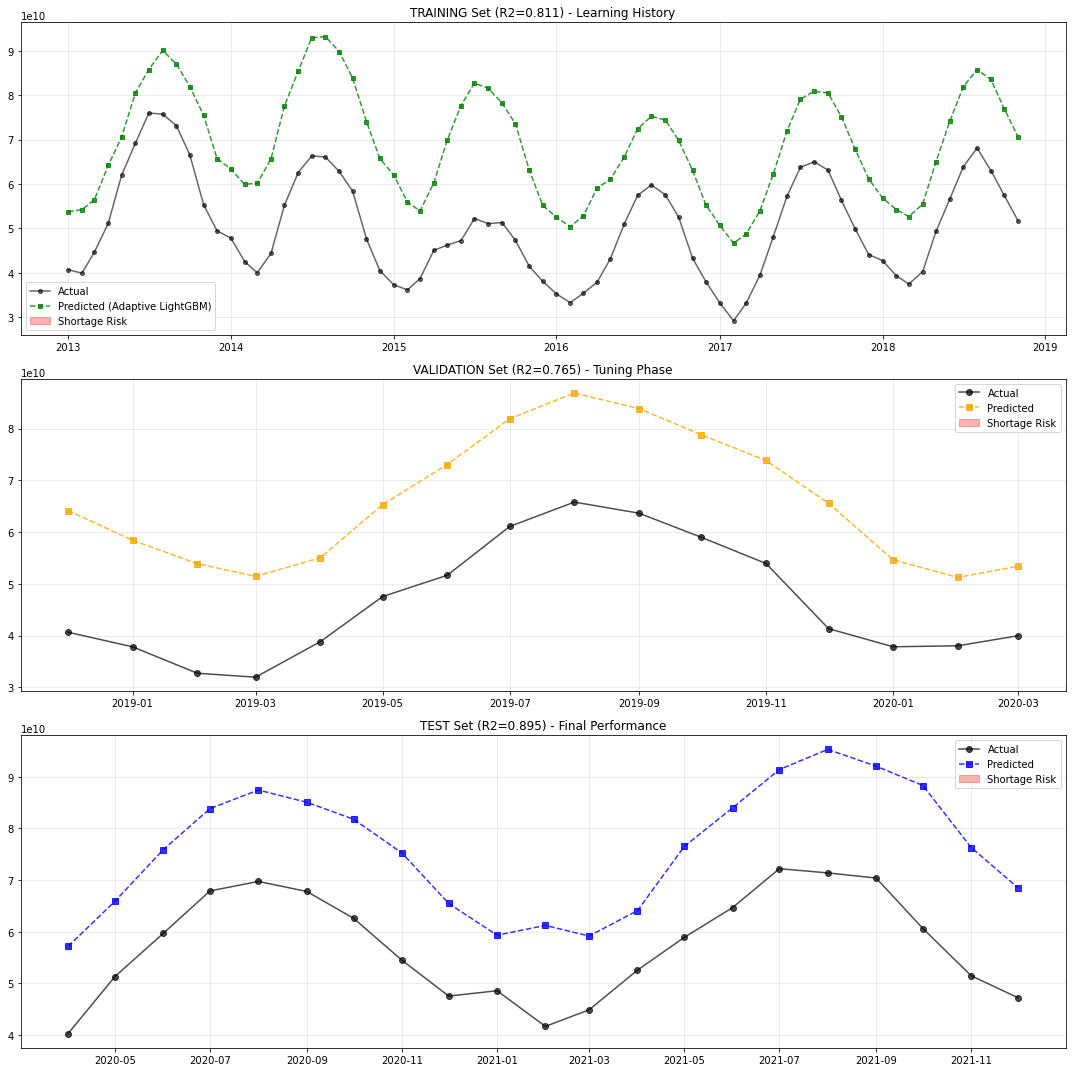


Generating Margin Efficiency Plot...


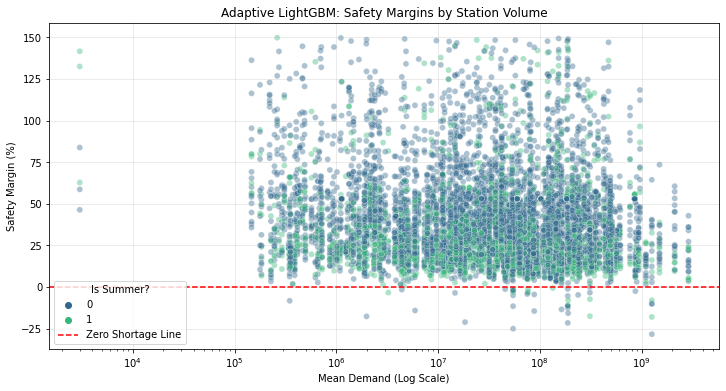


✅ PROCESS COMPLETE


In [9]:
# =============================================================================
# 7. FINAL EVALUATION & VISUALIZATION (TRAIN + VAL + TEST)
# =============================================================================

# --- 1. GENERATE PREDICTIONS FOR TRAINING SET ---
# Tự động phát hiện biến model đang có trong bộ nhớ
if 'model_xgb' in locals():
    raw_pred_train = model_xgb.predict(X_train)
    model_name_display = "Adaptive XGBoost"
elif 'model_cb' in locals():
    raw_pred_train = model_cb.predict(X_train)
    model_name_display = "Adaptive CatBoost"
elif 'model_lgb' in locals():
    raw_pred_train = model_lgb.predict(X_train)
    model_name_display = "Adaptive LightGBM"
else:
    raise ValueError("Không tìm thấy model (model_xgb, model_cb, hoặc model_lgb)!")

# Áp dụng Pipeline hậu xử lý cho Train (để visualize đồng bộ)
floored_pred_train = apply_smart_floor(raw_pred_train, train_df)
final_pred_train = apply_adaptive_buffer(floored_pred_train, train_df, risk_map)

# --- 2. CALCULATE METRICS ---
def evaluate_model(y_true, y_pred, df_original, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    under_pred_count = np.sum(y_pred < y_true)
    under_rate = (under_pred_count / len(y_true)) * 100
    over_rate = 100 - under_rate
    
    avg_shortage = np.mean(np.maximum(y_true - y_pred, 0))
    avg_surplus = np.mean(np.maximum(y_pred - y_true, 0))
    
    months = df_original['Month'].values
    summer_mask = (months >= 6) & (months <= 8)
    summer_under = 0.0
    if np.sum(summer_mask) > 0:
        summer_under = np.sum((y_pred[summer_mask] < y_true[summer_mask])) / np.sum(summer_mask) * 100
    
    print(f"\n📊 {dataset_name}:")
    print(f"   MAE: {mae:,.2f} | R²: {r2:.4f}")
    print(f"   ⚠️  Under-pred: {under_rate:.2f}% | Avg Shortage: {avg_shortage:,.2f}")
    print(f"   ✅ Over-pred: {over_rate:.2f}% | Avg Surplus: {avg_surplus:,.2f}")
    print(f"   🌞 Summer Under-pred: {summer_under:.2f}% (CRITICAL METRIC)")
    
    return {'R2': r2}

# Đánh giá cả 3 tập
train_metrics = evaluate_model(y_train, final_pred_train, train_df, "TRAINING SET")
val_metrics = evaluate_model(y_val, final_pred_val, val_df, "VALIDATION SET")
test_metrics = evaluate_model(y_test, final_pred_test, test_df, "TEST SET")

# --- 3. PLOTTING TIME SERIES (3 ROWS) ---
print("\n" + "="*60)
print("VISUALIZING RESULTS (TRAIN -> VAL -> TEST)")
print("="*60)

# Chuẩn bị dữ liệu vẽ (Group by Date để nhìn tổng quan)
def prepare_plot_data(df, y_true, y_pred):
    plot_df = df.copy()
    plot_df['Actual'] = y_true.values if hasattr(y_true, 'values') else y_true
    plot_df['Predicted'] = y_pred
    return plot_df.groupby('Date')[['Actual', 'Predicted']].sum().reset_index()

train_monthly = prepare_plot_data(train_df, y_train, final_pred_train)
val_monthly = prepare_plot_data(val_df, y_val, final_pred_val)
test_monthly = prepare_plot_data(test_df, y_test, final_pred_test)

# Vẽ 3 biểu đồ dọc
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

# Plot 1: Train
axes[0].plot(train_monthly['Date'], train_monthly['Actual'], 'k-o', label='Actual', alpha=0.6, markersize=4)
axes[0].plot(train_monthly['Date'], train_monthly['Predicted'], 'g--s', label=f'Predicted ({model_name_display})', alpha=0.8, markersize=4)
axes[0].fill_between(train_monthly['Date'], train_monthly['Predicted'], train_monthly['Actual'],
                     where=(train_monthly['Predicted'] < train_monthly['Actual']),
                     color='red', alpha=0.3, label='Shortage Risk')
axes[0].set_title(f"TRAINING Set (R2={train_metrics['R2']:.3f}) - Learning History")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Validation
axes[1].plot(val_monthly['Date'], val_monthly['Actual'], 'k-o', label='Actual', alpha=0.7)
axes[1].plot(val_monthly['Date'], val_monthly['Predicted'], 'orange', linestyle='--', marker='s', label='Predicted', alpha=0.8)
axes[1].fill_between(val_monthly['Date'], val_monthly['Predicted'], val_monthly['Actual'],
                     where=(val_monthly['Predicted'] < val_monthly['Actual']),
                     color='red', alpha=0.3, label='Shortage Risk')
axes[1].set_title(f"VALIDATION Set (R2={val_metrics['R2']:.3f}) - Tuning Phase")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Test
axes[2].plot(test_monthly['Date'], test_monthly['Actual'], 'k-o', label='Actual', alpha=0.7)
axes[2].plot(test_monthly['Date'], test_monthly['Predicted'], 'b--s', label='Predicted', alpha=0.8)
axes[2].fill_between(test_monthly['Date'], test_monthly['Predicted'], test_monthly['Actual'],
                     where=(test_monthly['Predicted'] < test_monthly['Actual']),
                     color='red', alpha=0.3, label='Shortage Risk')
axes[2].set_title(f"TEST Set (R2={test_metrics['R2']:.3f}) - Final Performance")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 4. MARGIN EFFICIENCY PLOT ---
print("\nGenerating Margin Efficiency Plot...")
# Cần tính mean_map cho biểu đồ
profile_df = pd.concat([train_df, val_df])
mean_map = profile_df.groupby('PWSID_enc')['Demand'].mean().to_dict()

test_analysis = test_df.copy()
test_analysis['Demand'] = y_test
test_analysis['Pred'] = final_pred_test
test_analysis['Margin_Pct'] = ((test_analysis['Pred'] - test_analysis['Demand']) / (test_analysis['Demand']+1)) * 100
test_analysis['Mean_Volume'] = test_analysis['PWSID_enc'].map(mean_map)

plt.figure(figsize=(12, 6))
plot_data = test_analysis[(test_analysis['Margin_Pct'] > -50) & (test_analysis['Margin_Pct'] < 150)]

sns.scatterplot(data=plot_data, x='Mean_Volume', y='Margin_Pct', hue='Is_Summer_Peak', alpha=0.4, palette='viridis')
plt.xscale('log')
plt.axhline(0, color='red', linestyle='--', label='Zero Shortage Line')
plt.title(f'{model_name_display}: Safety Margins by Station Volume')
plt.xlabel('Mean Demand (Log Scale)')
plt.ylabel('Safety Margin (%)')
plt.legend(title='Is Summer?')
plt.grid(True, alpha=0.3)
plt.show()

print("\n✅ PROCESS COMPLETE")

ADAPTIVE LIGHTGBM PIPELINE WITH SAFETY LAYER V2

📂 Loading data from CaRDS.csv...

🔨 Creating features...

📊 Splitting data...

STEP 1: TRAINING LIGHTGBM (Median/Alpha=0.5)
   ⏳ Training LightGBM...
Training until validation scores don't improve for 200 rounds
[500]	valid_0's quantile: 5.41054e+06
[1000]	valid_0's quantile: 4.4786e+06
[1500]	valid_0's quantile: 3.96613e+06
[2000]	valid_0's quantile: 3.58383e+06
[2500]	valid_0's quantile: 3.37104e+06
[3000]	valid_0's quantile: 3.24038e+06
Did not meet early stopping. Best iteration is:
[3000]	valid_0's quantile: 3.24038e+06

STEP 2 & 3: APPLYING WATER DEMAND SAFETY LAYER
   ⚙️ Fitting Safety Layer (Learning Risk Profiles)...
      -> Learned profiles for 404 stations.
   🚀 Generating forecasts with safety margins...

🔍 AUDIT LOG SAMPLE (Test Set - High Risk Cases):
Variable     Raw_Model  Floored_Pred   Risk_Buffer  Final_Forecast
87        2.803305e+09  2.803305e+09  5.852447e+08    3.388550e+09
88        3.096849e+09  3.096849e+09  5.

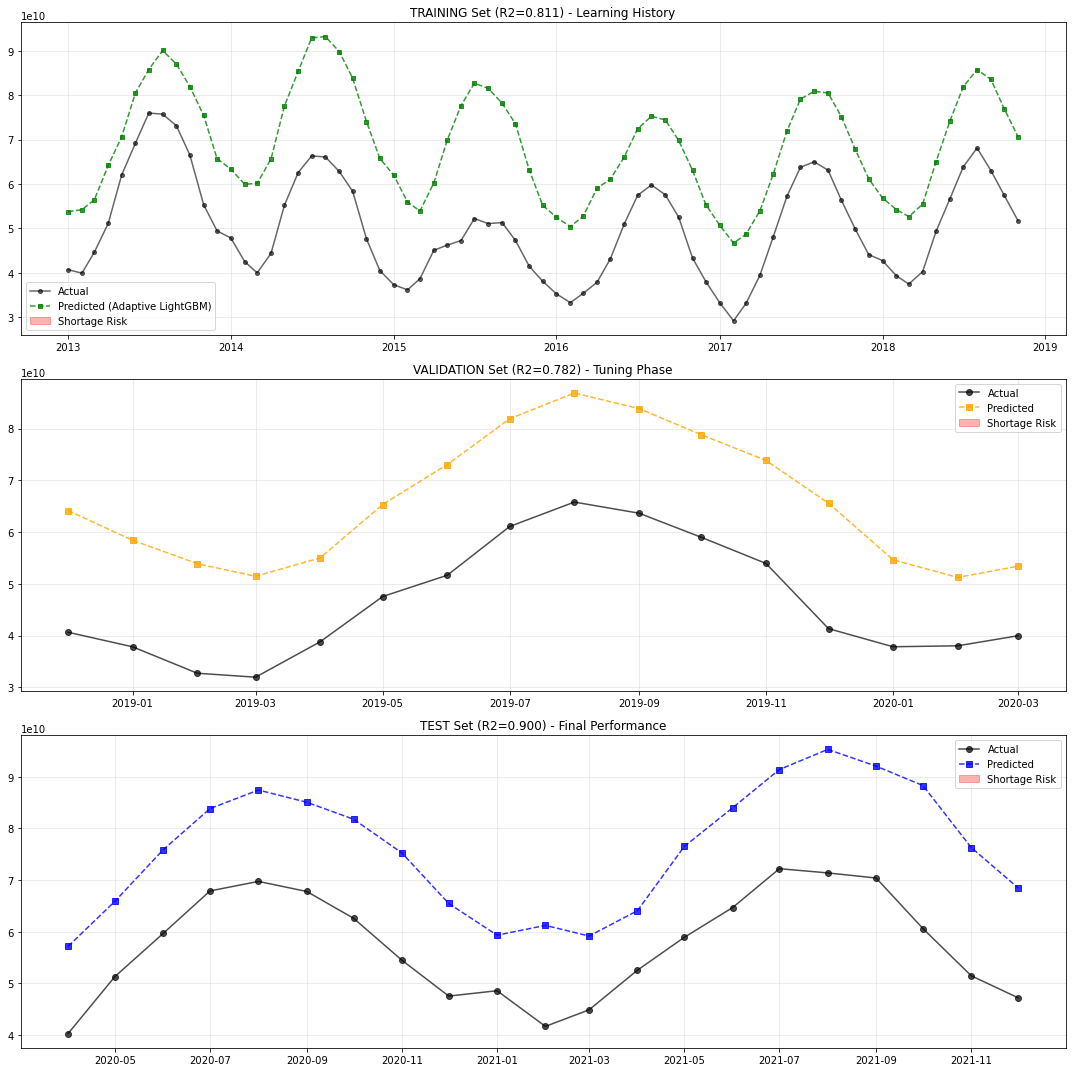


Generating Margin Efficiency Plot...


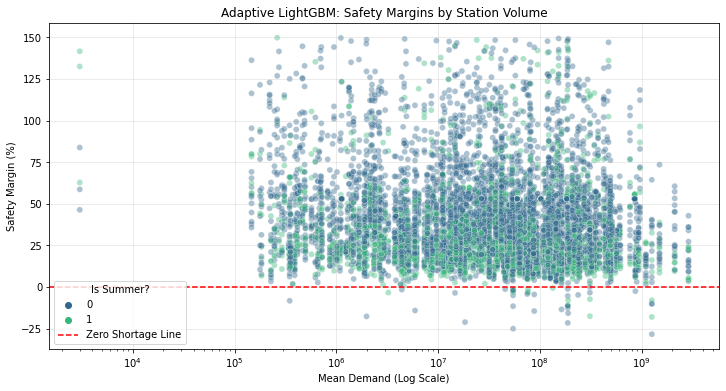


✅ PROCESS COMPLETE


In [11]:
# =============================================================================
# ADAPTIVE LIGHTGBM V2: CLASS-BASED SAFETY LAYER
# Architecture: Median Model -> Smart Floor -> Adaptive Risk Buffer
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import warnings
import os

warnings.filterwarnings('ignore')
np.random.seed(42)

# === CONFIGURATION ===
FILE_PATH = "CaRDS.csv"
TEST_SIZE = 0.2
VAL_SIZE = 0.15

# CẤU HÌNH LỚP AN TOÀN
SAFETY_CONFIG = {
    'summer_months': [6, 7, 8],
    'floor': {
        'enabled': True,
        'yoy_growth_min': 1.02,
        'mom_drop_max': 0.92,
        'mom_drop_summer': 0.95,
        'mom_drop_fall': 0.75
    },
    'buffer': {
        'enabled': True,
        'base_sigma': 2.0,
        'hist_coverage': 1.05,
        'summer_coverage': 1.15,
        'max_cap_pct': 0.50
    }
}

print("="*70)
print("ADAPTIVE LIGHTGBM PIPELINE WITH SAFETY LAYER V2")
print("="*70)

# =============================================================================
# 0. SAFETY LAYER CLASS
# =============================================================================
class WaterDemandSafetyLayer:
    def __init__(self, config):
        self.config = config
        self.risk_map = {} 

    def fit(self, df_val, y_true, y_pred_raw):
        print("   ⚙️ Fitting Safety Layer (Learning Risk Profiles)...")
        analysis = df_val[['PWSID_enc', 'Month']].copy()
        analysis['Actual'] = y_true.values if hasattr(y_true, 'values') else y_true
        analysis['Pred'] = y_pred_raw
        analysis['Shortage'] = analysis['Actual'] - analysis['Pred']
        
        risk_profile = analysis.groupby('PWSID_enc')['Shortage'].std().reset_index()
        risk_profile.rename(columns={'Shortage': 'Error_Std'}, inplace=True)
        
        shortage_only = analysis[analysis['Shortage'] > 0]
        if not shortage_only.empty:
            max_risk = shortage_only.groupby('PWSID_enc')['Shortage'].max().reset_index()
            max_risk.rename(columns={'Shortage': 'Max_Shortage'}, inplace=True)
        else:
            max_risk = pd.DataFrame(columns=['PWSID_enc', 'Max_Shortage'])
            
        summer_months = self.config['summer_months']
        summer_data = analysis[analysis['Month'].isin(summer_months)]
        summer_shortage = summer_data[summer_data['Shortage'] > 0]
        if not summer_shortage.empty:
            max_summer_risk = summer_shortage.groupby('PWSID_enc')['Shortage'].max().reset_index()
            max_summer_risk.rename(columns={'Shortage': 'Max_Summer_Shortage'}, inplace=True)
        else:
            max_summer_risk = pd.DataFrame(columns=['PWSID_enc', 'Max_Summer_Shortage'])

        profile = risk_profile.merge(max_risk, on='PWSID_enc', how='left')
        profile = profile.merge(max_summer_risk, on='PWSID_enc', how='left')
        profile = profile.fillna(0)
        self.risk_map = profile.set_index('PWSID_enc').to_dict('index')
        print(f"      -> Learned profiles for {len(self.risk_map)} stations.")

    def _apply_guardrails(self, base_pred, df_context):
        if not self.config['floor']['enabled']:
            return base_pred, np.zeros_like(base_pred, dtype=bool)

        cfg = self.config['floor']
        lag_12 = df_context['lag_12'].values
        lag_1 = df_context['lag_1'].values
        months = df_context['Month'].values
        
        floor_yoy = lag_12 * cfg['yoy_growth_min']
        floor_mom = lag_1 * cfg['mom_drop_max'] 
        
        summer_mask = np.isin(months, self.config['summer_months'])
        floor_mom[summer_mask] = lag_1[summer_mask] * cfg['mom_drop_summer']
        
        fall_mask = np.isin(months, [9, 10, 11])
        floor_mom[fall_mask] = lag_1[fall_mask] * cfg['mom_drop_fall']
        
        floored_pred = np.maximum.reduce([base_pred, floor_yoy, floor_mom])
        is_floored = floored_pred > (base_pred + 1e-3)
        return floored_pred, is_floored

    def _apply_risk_buffer(self, pred, df_context):
        if not self.config['buffer']['enabled']:
            return pred, np.zeros_like(pred)

        cfg = self.config['buffer']
        pwsid_encs = df_context['PWSID_enc'].values
        months = df_context['Month'].values
        
        buffers = []
        for i, pid in enumerate(pwsid_encs):
            profile = self.risk_map.get(pid, {'Error_Std': 0, 'Max_Shortage': 0, 'Max_Summer_Shortage': 0})
            
            base_buf = cfg['base_sigma'] * profile['Error_Std']
            hist_buf = profile['Max_Shortage'] * cfg['hist_coverage']
            
            summer_buf = 0
            if months[i] in self.config['summer_months']:
                summer_buf = profile['Max_Summer_Shortage'] * cfg['summer_coverage']
            
            final_buf = max(base_buf, hist_buf, summer_buf)
            
            if pred[i] > 0:
                cap_val = pred[i] * cfg['max_cap_pct']
                if final_buf > cap_val and final_buf > profile['Max_Shortage'] * 1.1:
                    final_buf = cap_val
            
            buffers.append(final_buf)
            
        return pred + np.array(buffers), np.array(buffers)

    def predict(self, raw_pred, df_context, explain=False):
        floored_pred, is_floored = self._apply_guardrails(raw_pred, df_context)
        final_pred, buffer_amount = self._apply_risk_buffer(floored_pred, df_context)
        
        if explain:
            explanation_df = df_context.copy()
            explanation_df['Raw_Model'] = raw_pred
            explanation_df['Floored_Pred'] = floored_pred
            explanation_df['Is_Floored'] = is_floored
            explanation_df['Risk_Buffer'] = buffer_amount
            explanation_df['Final_Forecast'] = final_pred
            return final_pred, explanation_df
        return final_pred

# =============================================================================
# 1. DATA & FEATURE ENGINEERING
# =============================================================================
def clean_physics_based(series):
    median_val = series.median()
    if pd.isna(median_val) or median_val <= 0: return series.fillna(0)
    phys_min = median_val * 0.05
    phys_max = median_val * 10.0
    mask_invalid = (series < phys_min) | (series > phys_max)
    if mask_invalid.any():
        series_clean = series.copy()
        series_clean[mask_invalid] = np.nan
        return series_clean.interpolate(method='linear', limit_direction='both')
    return series

def load_and_process_data(file_path):
    print(f"\n📂 Loading data from {file_path}...")
    if not os.path.exists(file_path):
        print(f"❌ Error: File not found.")
        return None
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"❌ Error reading file: {e}")
        return None

    df['Variable'] = df['Variable'].astype(str).str.strip().str.lower()
    date_cols = [c for c in df.columns if c not in ['PWSID', 'Variable']]
    df_melt = df.melt(id_vars=['PWSID', 'Variable'], value_vars=date_cols, var_name='Date', value_name='Value')
    df_pivot = df_melt.pivot_table(index=['PWSID', 'Date'], columns='Variable', values='Value').reset_index()
    
    rename_map = {'demand': 'Demand', 'temperature': 'Temperature', 'precipitation': 'Precipitation', 'pdsi': 'PDSI'}
    df_pivot.rename(columns=rename_map, inplace=True)
    df_pivot['Date'] = pd.to_datetime(df_pivot['Date'])
    df_final = df_pivot.sort_values(['PWSID', 'Date']).reset_index(drop=True)
    
    for col in ['Temperature', 'Precipitation', 'PDSI']:
        if col in df_final.columns:
            val = 0 if col == 'Precipitation' else df_final[col].median()
            df_final[col] = df_final[col].fillna(val)
    
    if 'Demand' in df_final.columns:
        df_final['Demand'] = df_final.groupby('PWSID')['Demand'].transform(clean_physics_based)
        df_final['Demand'] = df_final['Demand'].fillna(0)
    return df_final

def create_features(df):
    print("\n🔨 Creating features...")
    df = df.copy()
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Is_Summer_Peak'] = ((df['Month'] >= 6) & (df['Month'] <= 8)).astype(int)
    
    if 'Temperature' in df.columns:
        df['Temp_mean_3m'] = df.groupby('PWSID')['Temperature'].transform(lambda x: x.rolling(3, min_periods=1).mean())
        df['CDD'] = np.maximum(df['Temperature'] - 18, 0)
    
    df['lag_1'] = df.groupby('PWSID')['Demand'].shift(1)
    df['lag_12'] = df.groupby('PWSID')['Demand'].shift(12)
    df['rolling_mean_12'] = df.groupby('PWSID')['Demand'].transform(lambda x: x.rolling(12, min_periods=1).mean())
    df['diff_12'] = df.groupby('PWSID')['Demand'].diff(12)
    
    if 'Temperature' in df.columns:
        df['Temp_lag_1'] = df.groupby('PWSID')['Temperature'].shift(1)
        df['Summer_Heat_Interaction'] = df['Is_Summer_Peak'] * df['CDD']
    if 'Precipitation' in df.columns:
        df['Precip_lag_1'] = df.groupby('PWSID')['Precipitation'].shift(1)
    
    return df.fillna(method='bfill').fillna(0)

# EXECUTE DATA LOADING
df = load_and_process_data(FILE_PATH)
if df is None: exit()
df_features = create_features(df)

# =============================================================================
# 2. SPLITTING DATA
# =============================================================================
print("\n📊 Splitting data...")
unique_dates = df_features['Date'].sort_values().unique()
n_test = int(len(unique_dates) * TEST_SIZE)
n_val = int(len(unique_dates) * VAL_SIZE)

test_start = unique_dates[-n_test]
val_start = unique_dates[-(n_test + n_val)]

train_df = df_features[df_features['Date'] < val_start].copy()
val_df = df_features[(df_features['Date'] >= val_start) & (df_features['Date'] < test_start)].copy()
test_df = df_features[df_features['Date'] >= test_start].copy()

le = LabelEncoder()
train_df['PWSID_enc'] = le.fit_transform(train_df['PWSID'])
val_df['PWSID_enc'] = le.transform(val_df['PWSID'])
test_df['PWSID_enc'] = le.transform(test_df['PWSID'])

common_pwsids = set(train_df['PWSID']) & set(val_df['PWSID']) & set(test_df['PWSID'])
train_df = train_df[train_df['PWSID'].isin(common_pwsids)]
val_df = val_df[val_df['PWSID'].isin(common_pwsids)]
test_df = test_df[test_df['PWSID'].isin(common_pwsids)]

features = ['PWSID_enc', 'Month', 'Year', 'Is_Summer_Peak',
            'lag_1', 'lag_12', 'diff_12', 'rolling_mean_12',
            'Temp_lag_1', 'CDD', 'Summer_Heat_Interaction', 'Precip_lag_1']
features = [c for c in features if c in train_df.columns]

X_train = train_df[features]
y_train = train_df['Demand']
X_val = val_df[features]
y_val = val_df['Demand']
X_test = test_df[features]
y_test = test_df['Demand']

# =============================================================================
# 3. TRAINING MODEL (PREDICTION LAYER)
# =============================================================================
print("\n" + "="*70)
print("STEP 1: TRAINING LIGHTGBM (Median/Alpha=0.5)")
print("="*70)

weights = np.ones(len(X_train))
weights[(train_df['Month'] >= 6) & (train_df['Month'] <= 8)] = 1.3

lgb_params = {
    'objective': 'quantile',      
    'alpha': 0.5, # Median
    'metric': 'quantile',
    'boosting_type': 'gbdt',
    'learning_rate': 0.02,
    'num_leaves': 31,
    'max_depth': 7,
    'n_estimators': 3000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
}

model_lgb = lgb.LGBMRegressor(**lgb_params)

print("   ⏳ Training LightGBM...")
callbacks = [
    lgb.early_stopping(stopping_rounds=200),
    lgb.log_evaluation(period=500)
]

model_lgb.fit(
    X_train, y_train,
    sample_weight=weights,
    eval_set=[(X_val, y_val)],
    eval_metric='quantile',
    callbacks=callbacks
)

# Raw Predictions
raw_pred_val = model_lgb.predict(X_val)
raw_pred_test = model_lgb.predict(X_test)

# =============================================================================
# 4. APPLYING SAFETY LAYER (CORRECTION & RISK BUFFER)
# =============================================================================
print("\n" + "="*70)
print("STEP 2 & 3: APPLYING WATER DEMAND SAFETY LAYER")
print("="*70)

# Khởi tạo class
safety_layer = WaterDemandSafetyLayer(config=SAFETY_CONFIG)

# 1. Fit
safety_layer.fit(val_df, y_val, raw_pred_val)

# 2. Predict & Explain
print("   🚀 Generating forecasts with safety margins...")
final_val_pred, val_explain = safety_layer.predict(raw_pred_val, val_df, explain=True)
final_test_pred, test_explain = safety_layer.predict(raw_pred_test, test_df, explain=True)

# Audit Log
print("\n🔍 AUDIT LOG SAMPLE (Test Set - High Risk Cases):")
print(test_explain[test_explain['Risk_Buffer'] > 1000].head(3)[['Raw_Model', 'Floored_Pred', 'Risk_Buffer', 'Final_Forecast']])

# =============================================================================
# 5. EVALUATION & VISUALIZATION (STANDARD BLOCK)
# =============================================================================
print("\n" + "="*70)
print("FINAL EVALUATION & VISUALIZATION")
print("="*70)

# 1. Mean Map Calculation
profile_df = pd.concat([train_df, val_df])
mean_map = profile_df.groupby('PWSID_enc')['Demand'].mean().to_dict()

# 2. Evaluation Function
def evaluate_model(y_true, y_pred, df_original, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    threshold = pd.Series(y_true).quantile(0.1)
    mask = y_true > threshold
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + 1e-10))) * 100
    else:
        mape = 0.0
    
    under_pred_count = np.sum(y_pred < y_true)
    under_rate = (under_pred_count / len(y_true)) * 100
    over_rate = 100 - under_rate
    
    avg_shortage = np.mean(np.maximum(y_true - y_pred, 0))
    avg_surplus = np.mean(np.maximum(y_pred - y_true, 0))
    
    months = df_original['Month'].values
    summer_mask = (months >= 6) & (months <= 8)
    if np.sum(summer_mask) > 0:
        summer_under = np.sum((y_pred[summer_mask] < y_true[summer_mask])) / np.sum(summer_mask) * 100
    else:
        summer_under = 0.0
    
    print(f"\n📊 {dataset_name}:")
    print(f"   MAE: {mae:,.2f} | R²: {r2:.4f}")
    print(f"   MAPE (filtered): {mape:.2f}%")
    print(f"   ⚠️  Under-pred: {under_rate:.1f}% | Avg Shortage: {avg_shortage:,.2f}")
    print(f"   ✅ Over-pred: {over_rate:.1f}% | Avg Surplus: {avg_surplus:,.2f}")
    print(f"   🌞 Summer Under-pred: {summer_under:.1f}% (CRITICAL METRIC)")
    
    return {'R2': r2}

val_metrics = evaluate_model(y_val, final_val_pred, val_df, "VALIDATION SET")
test_metrics = evaluate_model(y_test, final_test_pred, test_df, "TEST SET")

# --- 3. PLOTTING TIME SERIES (3 ROWS) ---
print("\n" + "="*60)
print("VISUALIZING RESULTS (TRAIN -> VAL -> TEST)")
print("="*60)

# Chuẩn bị dữ liệu vẽ (Group by Date để nhìn tổng quan)
def prepare_plot_data(df, y_true, y_pred):
    plot_df = df.copy()
    plot_df['Actual'] = y_true.values if hasattr(y_true, 'values') else y_true
    plot_df['Predicted'] = y_pred
    return plot_df.groupby('Date')[['Actual', 'Predicted']].sum().reset_index()

train_monthly = prepare_plot_data(train_df, y_train, final_pred_train)
val_monthly = prepare_plot_data(val_df, y_val, final_pred_val)
test_monthly = prepare_plot_data(test_df, y_test, final_pred_test)

# Vẽ 3 biểu đồ dọc
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

# Plot 1: Train
axes[0].plot(train_monthly['Date'], train_monthly['Actual'], 'k-o', label='Actual', alpha=0.6, markersize=4)
axes[0].plot(train_monthly['Date'], train_monthly['Predicted'], 'g--s', label=f'Predicted ({model_name_display})', alpha=0.8, markersize=4)
axes[0].fill_between(train_monthly['Date'], train_monthly['Predicted'], train_monthly['Actual'],
                     where=(train_monthly['Predicted'] < train_monthly['Actual']),
                     color='red', alpha=0.3, label='Shortage Risk')
axes[0].set_title(f"TRAINING Set (R2={train_metrics['R2']:.3f}) - Learning History")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Validation
axes[1].plot(val_monthly['Date'], val_monthly['Actual'], 'k-o', label='Actual', alpha=0.7)
axes[1].plot(val_monthly['Date'], val_monthly['Predicted'], 'orange', linestyle='--', marker='s', label='Predicted', alpha=0.8)
axes[1].fill_between(val_monthly['Date'], val_monthly['Predicted'], val_monthly['Actual'],
                     where=(val_monthly['Predicted'] < val_monthly['Actual']),
                     color='red', alpha=0.3, label='Shortage Risk')
axes[1].set_title(f"VALIDATION Set (R2={val_metrics['R2']:.3f}) - Tuning Phase")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Test
axes[2].plot(test_monthly['Date'], test_monthly['Actual'], 'k-o', label='Actual', alpha=0.7)
axes[2].plot(test_monthly['Date'], test_monthly['Predicted'], 'b--s', label='Predicted', alpha=0.8)
axes[2].fill_between(test_monthly['Date'], test_monthly['Predicted'], test_monthly['Actual'],
                     where=(test_monthly['Predicted'] < test_monthly['Actual']),
                     color='red', alpha=0.3, label='Shortage Risk')
axes[2].set_title(f"TEST Set (R2={test_metrics['R2']:.3f}) - Final Performance")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 4. MARGIN EFFICIENCY PLOT ---
print("\nGenerating Margin Efficiency Plot...")
# Cần tính mean_map cho biểu đồ
profile_df = pd.concat([train_df, val_df])
mean_map = profile_df.groupby('PWSID_enc')['Demand'].mean().to_dict()

test_analysis = test_df.copy()
test_analysis['Demand'] = y_test
test_analysis['Pred'] = final_pred_test
test_analysis['Margin_Pct'] = ((test_analysis['Pred'] - test_analysis['Demand']) / (test_analysis['Demand']+1)) * 100
test_analysis['Mean_Volume'] = test_analysis['PWSID_enc'].map(mean_map)

plt.figure(figsize=(12, 6))
plot_data = test_analysis[(test_analysis['Margin_Pct'] > -50) & (test_analysis['Margin_Pct'] < 150)]

sns.scatterplot(data=plot_data, x='Mean_Volume', y='Margin_Pct', hue='Is_Summer_Peak', alpha=0.4, palette='viridis')
plt.xscale('log')
plt.axhline(0, color='red', linestyle='--', label='Zero Shortage Line')
plt.title(f'{model_name_display}: Safety Margins by Station Volume')
plt.xlabel('Mean Demand (Log Scale)')
plt.ylabel('Safety Margin (%)')
plt.legend(title='Is Summer?')
plt.grid(True, alpha=0.3)
plt.show()

print("\n✅ PROCESS COMPLETE")
